In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
total_features_4 = np.load(f'../data/features/exp_4_total_data.npy', allow_pickle=True)
total_features_5 = np.load(f'../data/features/exp_5_total_data.npy', allow_pickle=True)
total_features = np.concatenate((total_features_4, total_features_5), axis=0)

total_labels_4 = np.load(f'../data/roi-video/exp_4_total_label.npy')
total_labels_5 = np.load(f'../data/roi-video/exp_5_total_label.npy')
total_labels = np.concatenate((total_labels_4, total_labels_5), axis=0)

total_cultivar = np.load(f'../data/roi-video/total_cultivar.npy')

print(f'round 4: features shape: {total_features_4.shape}, labels shape: {total_labels_4.shape}')
print(f'round 5: features shape: {total_features_5.shape}, labels shape: {total_labels_5.shape}')
print(f'total: features shape: {total_features.shape}, labels shape: {total_labels.shape}')
print(f'total cultivar: {total_cultivar.shape}')

round 4: features shape: (1475,), labels shape: (1475,)
round 5: features shape: (1434,), labels shape: (1434,)
total: features shape: (2909,), labels shape: (2909,)
total cultivar: (2909,)


In [3]:
# Convert total features (list of maps) to a DataFrame
features_df_4 = pd.DataFrame(total_features_4.flatten().tolist())
features_df_5 = pd.DataFrame(total_features_5.flatten().tolist())
features_df = pd.DataFrame(total_features.flatten().tolist())
features_df['cultivar'] = total_cultivar

# Add labels to the DataFrame
features_df_4['mortality'] = total_labels_4[:]  # Binary target variable
features_df_5['mortality'] = total_labels_5[:]  # Binary target variable
features_df['mortality'] = total_labels[:]  # Binary target variable

In [4]:
features_df.head(1)

,pc0,pc1,pc2,rising_waveform,falling_waveform,peak_temperature,cultivar,mortality
0,-1341.880204,440.260035,28.227647,0.92679,0.435865,250.233182,1,1.0


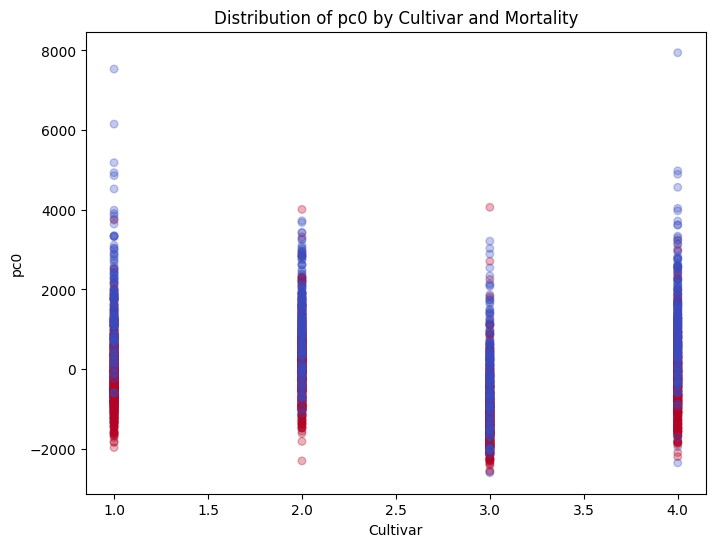

In [7]:
# plots dot plot for specific feature with different cultivars, color coded by mortality
def plot_feature(feature_name, feature_df):
    # Plot the distribution of the feature
    plt.figure(figsize=(8, 6))
    plt.scatter(feature_df['cultivar'], feature_df[feature_name], c=feature_df['mortality'], cmap='coolwarm', alpha=0.3, s=30)
    plt.xlabel('Cultivar')
    plt.ylabel(feature_name)
    plt.title(f'Distribution of {feature_name} by Cultivar and Mortality')
    plt.show()


plot_feature('pc0', features_df)

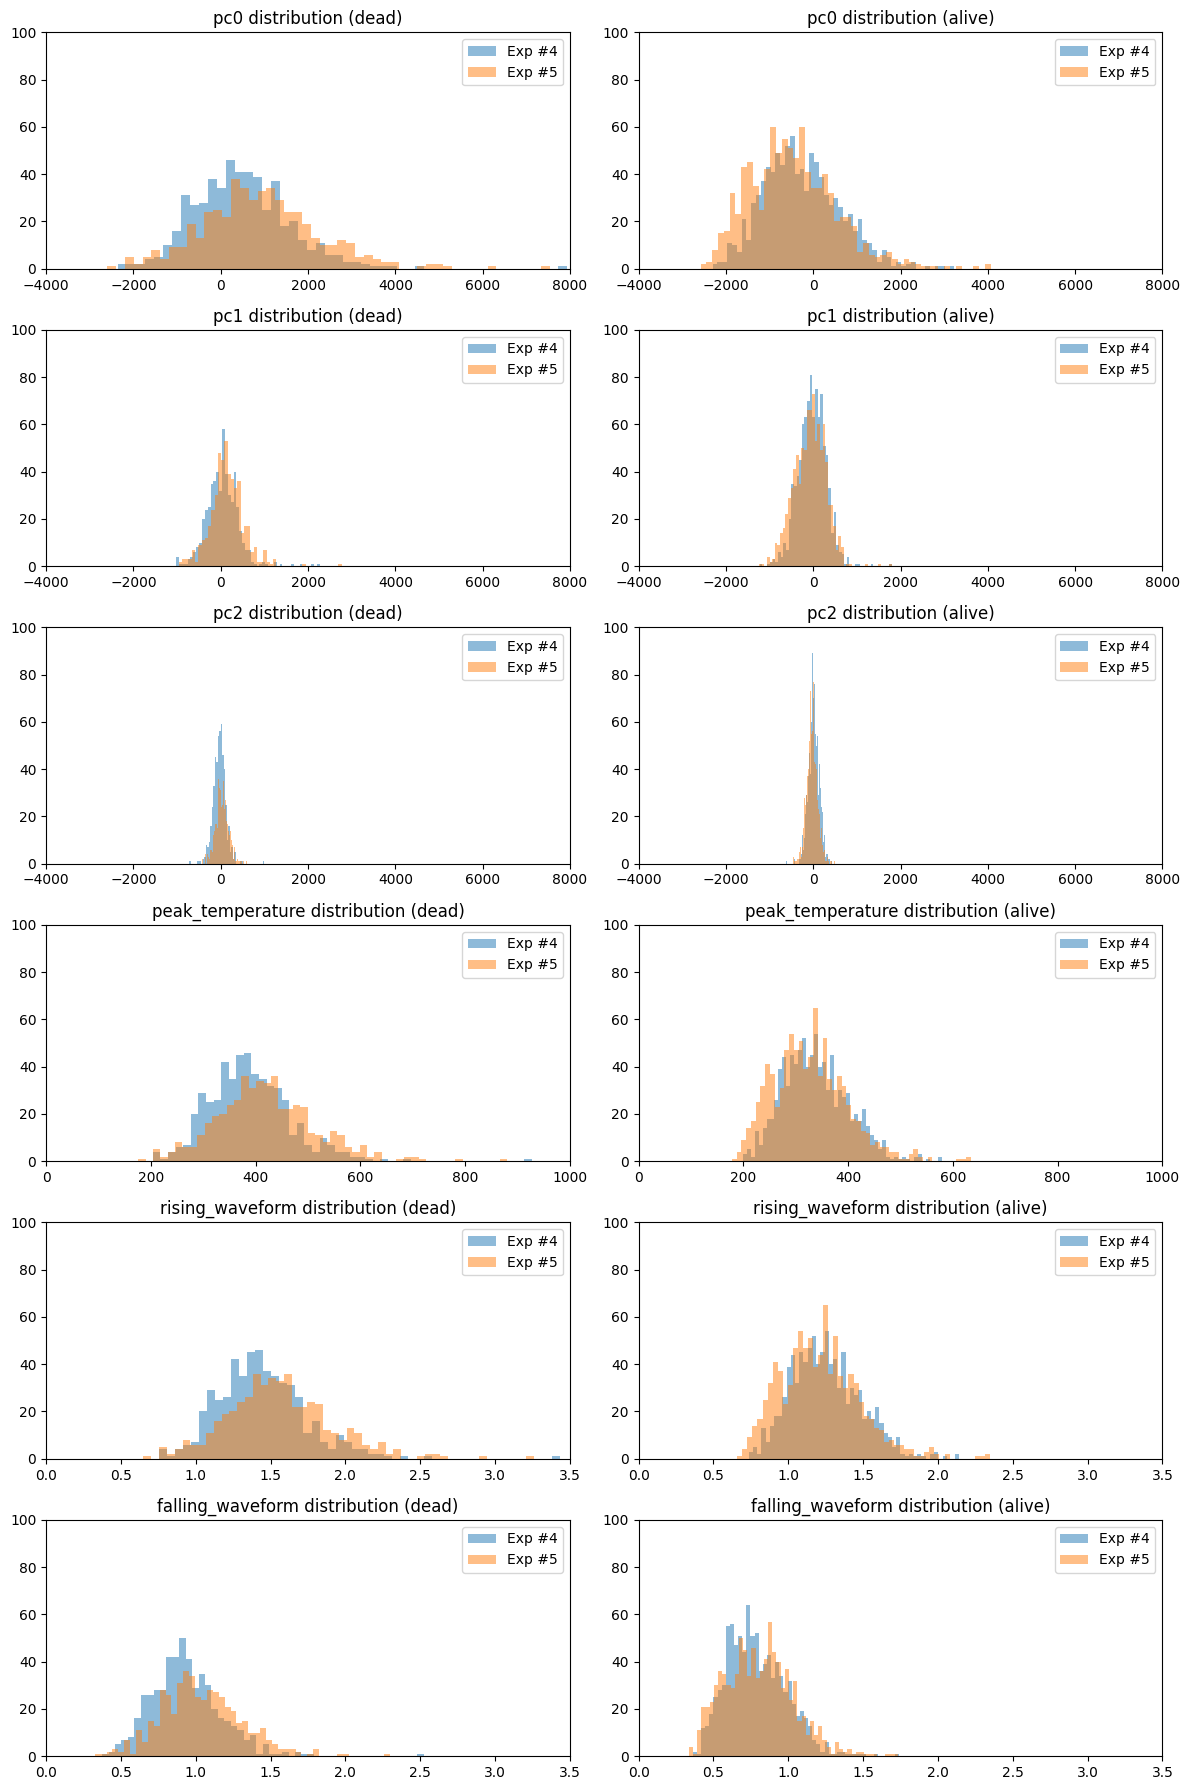

In [8]:
# Define features and mortality classes
features = ['pc0', 'pc1', 'pc2', 'peak_temperature', 'rising_waveform', 'falling_waveform']
mortality_classes = [0, 1]

fig, axes = plt.subplots(len(features), 2, figsize=(12, 3 * len(features)))

for row, feature in enumerate(features):
    for col, m in enumerate(mortality_classes):
        axes[row, col].hist(features_df_4[features_df_4['mortality'] == m][feature], bins=50, alpha=0.5, label='Exp #4')
        axes[row, col].hist(features_df_5[features_df_5['mortality'] == m][feature], bins=50, alpha=0.5, label='Exp #5')
        axes[row, col].set_title(f'{feature} distribution ({"alive" if m == 1 else "dead"})')
        axes[row, col].legend()
        axes[row, col].set_ylim((0, 100))
        if 'pc' in feature:
            axes[row, col].set_xlim((-4000, 8000))
        elif 'temperature' in feature:
            axes[row, col].set_xlim((0, 1000))
        else:
            axes[row, col].set_xlim((0, 3.5))

plt.tight_layout()
plt.show()


In [19]:
# Define features
features = ['pc0', 'pc1', 'pc2', 'peak_temperature', 'rising_waveform', 'falling_waveform']
mortality_classes = [0, 1]

# Initialize results storage
stat_results = []

for feature in features:
    for mortality in mortality_classes:
        # Extract feature data for the given mortality class
        data_4 = features_df_4[features_df_4['mortality'] == mortality][feature].dropna()
        data_5 = features_df_5[features_df_5['mortality'] == mortality][feature].dropna()
        
        # Perform Kolmogorov-Smirnov test
        ks_stat, ks_pval = stats.ks_2samp(data_4, data_5)
        
        # Perform t-test (checking if means are significantly different)
        t_stat, t_pval = stats.ttest_ind(data_4, data_5, equal_var=False)
        
        # Store results
        stat_results.append([feature + ': mortality' + str(mortality), ks_pval, t_pval])

# Convert results to DataFrame for better visualization
stat_results_df = pd.DataFrame(stat_results, columns=['Feature', 'KS p-value', 'T p-value'])
print(stat_results_df)

                         Feature    KS p-value     T p-value
0                pc0: mortality0  2.037266e-07  1.417893e-08
1                pc0: mortality1  3.707757e-07  1.204556e-06
2                pc1: mortality0  3.505598e-05  1.411804e-05
3                pc1: mortality1  4.022529e-04  7.618906e-04
4                pc2: mortality0  9.760781e-06  7.599152e-08
5                pc2: mortality1  1.013272e-09  2.253193e-11
6   peak_temperature: mortality0  3.598710e-08  6.729180e-09
7   peak_temperature: mortality1  2.791543e-05  3.167705e-04
8    rising_waveform: mortality0  3.598710e-08  6.729180e-09
9    rising_waveform: mortality1  2.791543e-05  3.167705e-04
10  falling_waveform: mortality0  2.084958e-08  2.862390e-10
11  falling_waveform: mortality1  8.171535e-03  7.451957e-02


In [ ]:
round_num = 2

csv_file = f'../../roi_data/csv/stat_all_data_noabnormal_extend_mean_normalization_pca_round_{round_num}.csv'
df = pd.read_csv(csv_file)

# Count mortality for each cultivar
cultivars = ['CF', 'CON', 'PN', 'RIES']
for cultivar in cultivars:
    for mortality in [1, 0]:
        mortality_status = 'alive' if mortality == 1 else 'dead'
        count = df[(df['cultivar'] == cultivar) & (df['mortality'] == mortality)].shape[0]
        print(f'Count of cultivar "{cultivar}" with mortality {mortality_status}: {count}')


Count of cultivar "CF" with mortality alive: 211
Count of cultivar "CF" with mortality dead: 127
Count of cultivar "CON" with mortality alive: 209
Count of cultivar "CON" with mortality dead: 28
Count of cultivar "PN" with mortality alive: 210
Count of cultivar "PN" with mortality dead: 114
Count of cultivar "RIES" with mortality alive: 217
Count of cultivar "RIES" with mortality dead: 110


: 